# ParticleNetのトレーニングと評価

In [31]:
import os
import logging
logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(levelname)s: %(message)s')
logging.disable(logging.DEBUG)

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from weaver.nn.model import ParticleNet

## ハイパーパラメータの設定

In [32]:
from torch.optim.lr_scheduler import _LRScheduler

class LinearCyclicalLR(_LRScheduler):
        def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
            self.T_max = T_max
            self.eta_min = eta_min
            super(LinearCyclicalLR, self).__init__(optimizer, last_epoch)

        def get_lr(self):
            last_step = self.last_epoch % self.T_max
            point = self.T_max // 2
            return [-(base_lr-self.eta_min)* last_step / (point-0.5) + base_lr if last_step < point
                    else (base_lr-self.eta_min)*last_step/(point-0.5) + self.eta_min - base_lr
                    for base_lr in self.base_lrs]

# 論文からのパラメータ(ParticleNet-Lite)
batch_size = 1024

# learning rate scheduler parameters
lr_init = 5e-4
lr_max = 5e-3
lr_T = 16

# AdamW parameters
weight_decay = 1e-4

# model parameters
conv_params = [(7, (32, 32, 32)), (7, (64, 64, 64))]
fc_params = [(128, 0.1)]

# epochs
epochs = 100

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## データセットの作成

In [34]:
dir_path = "./processed"
# dir_path = "/home/suzukiy/ftag/particlenet-toptagging/processed"

var_part_names = [
    "part_etarel",
    "part_phirel",
    "part_pt_log",
    "part_e_log",
    "part_logptrel",
    "part_logerel",
    "part_deltaR",
]

coords_part_names = [
    "part_etarel",
    "part_phirel",
]

In [35]:
dict_ttv = {}
for ttv in ["train", "test", "val"]:
    var = {}
    coords = {}
    
    logging.info(f"Loading {ttv} data...")
    
    with h5py.File(os.path.join(dir_path, f"{ttv}_file_0.h5"), "r") as f:
        _label = f["label"][:]
        label = np.stack((_label, 1-_label), axis=-1) # one-hot encoding
        mask = f["mask"][:]
        for k in var_part_names:
            var[k] = f[k][:]
        for k in coords_part_names:
            coords[k] = f[k][:]
    
    dict_ttv[ttv] = {
        "label": label,
        "mask": mask,
        "var": np.stack([var[k] for k in var_part_names], axis=1),
        "coords": np.stack([coords[k] for k in coords_part_names], axis=1),
    }
    
    logging.info(f"Loaded {ttv} data.")

[2023-01-26 11:30:42,539] INFO: Loading train data...
[2023-01-26 11:31:56,828] INFO: Loaded train data.
[2023-01-26 11:31:56,998] INFO: Loading test data...
[2023-01-26 11:32:21,094] INFO: Loaded test data.
[2023-01-26 11:32:21,163] INFO: Loading val data...
[2023-01-26 11:32:47,598] INFO: Loaded val data.


In [116]:
print("train data shape:", dict_ttv["train"]["var"].shape)
print("test data shape:", dict_ttv["test"]["var"].shape)
print("val data shape:", dict_ttv["val"]["var"].shape)

train data shape: (1211000, 7, 200)
test data shape: (404000, 7, 200)
val data shape: (403000, 7, 200)


In [36]:
tensor_points_train = torch.from_numpy(dict_ttv["train"]["coords"]).float()
tensor_points_val = torch.from_numpy(dict_ttv["val"]["coords"]).float()
tensor_points_test = torch.from_numpy(dict_ttv["test"]["coords"]).float()

tensor_features_train = torch.from_numpy(dict_ttv["train"]["var"]).float()
tensor_features_val = torch.from_numpy(dict_ttv["val"]["var"]).float()
tensor_features_test = torch.from_numpy(dict_ttv["test"]["var"]).float()

tensor_y_train = torch.from_numpy(dict_ttv["train"]["label"]).float()
tensor_y_val = torch.from_numpy(dict_ttv["val"]["label"]).float()
tensor_y_test = torch.from_numpy(dict_ttv["test"]["label"]).float()

tensor_mask_train = torch.from_numpy(dict_ttv["train"]["mask"]).float()
tensor_mask_val = torch.from_numpy(dict_ttv["val"]["mask"]).float()
tensor_mask_test = torch.from_numpy(dict_ttv["test"]["mask"]).float()

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(tensor_points_train, tensor_features_train, tensor_mask_train, tensor_y_train),
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(tensor_points_val, tensor_features_val, tensor_mask_val, tensor_y_val),
    batch_size=batch_size,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(tensor_points_test, tensor_features_test, tensor_mask_test, tensor_y_test),
    batch_size=batch_size,
    shuffle=False
)


In [37]:
for i, (points, features, mask, y) in enumerate(train_loader):
    print(points.shape)
    print(features.shape)
    print(mask.shape)
    print(y.shape)
    break

torch.Size([1024, 2, 200])
torch.Size([1024, 7, 200])
torch.Size([1024, 1, 200])
torch.Size([1024, 2])


## モデルの作成

In [38]:
model = ParticleNet.ParticleNet(
    input_dims=len(var_part_names), # 7
    num_classes=2,
    conv_params=conv_params,
    fc_params=fc_params,
    use_fusion=True,
    use_fts_bn=True,
    use_counts=True,
    for_inference=False,
    for_segmentation=False,
)

if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr_init, weight_decay=weight_decay)
scheduler = LinearCyclicalLR(optimizer, lr_T, eta_min=lr_init, last_epoch=-1)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction="none")

In [63]:
def train(model, dataloader, optimizer, loss_fn, scheduler, epoch, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    for i, (points, features, mask, y) in enumerate(dataloader):
        points = points.to(device)
        features = features.to(device)
        mask = mask.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(points, features, mask)
        # print(y_pred.detach().cpu().numpy())
        loss = loss_fn(y_pred, y)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        total_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        total += y.shape[0]
    return total_loss / len(dataloader), total_correct / total

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for i, (points, features, mask, y) in enumerate(dataloader):
            points = points.to(device)
            features = features.to(device)
            mask = mask.to(device)
            y = y.to(device)
            y_pred = model(points, features, mask)
            loss = loss_fn(y_pred, y)
            loss = loss.mean()
            total_loss += loss.item()
            total_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
            total += y.shape[0]
    return total_loss / len(dataloader), total_correct / total

def test(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    y_preds = []
    with torch.no_grad():
        for i, (points, features, mask, y) in enumerate(dataloader):
            points = points.to(device)
            features = features.to(device)
            mask = mask.to(device)
            y = y.to(device)
            y_pred = model(points, features, mask)
            loss = loss_fn(y_pred, y)
            loss = loss.mean()
            total_loss += loss.item()
            total_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
            total += y.shape[0]
            y_preds.append(y_pred)
    return total_loss / len(dataloader), total_correct / total, torch.cat(y_preds, dim=0).detach().cpu().numpy()

In [ ]:
# 学習
# 1epochあたりの時間はだいたい3分くらい
torch.autograd.set_detect_anomaly(True)
history = []
for t in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, scheduler, t, device)
    val_loss, val_acc = validate(model, val_loader, loss_fn, device)
    logging.info(f"Epoch {t}: train loss {train_loss:.4f}, train acc {train_acc:.4f}, val loss {val_loss:.4f}, val acc {val_acc:.4f}")
    history.append([t, train_loss, train_acc, val_loss, val_acc])
    torch.save(model.state_dict(), f"./models/model_{str(t).zfill(3)}.pth")

df_history = pd.DataFrame(history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
df_history.to_csv("./models/history.csv", index=False)

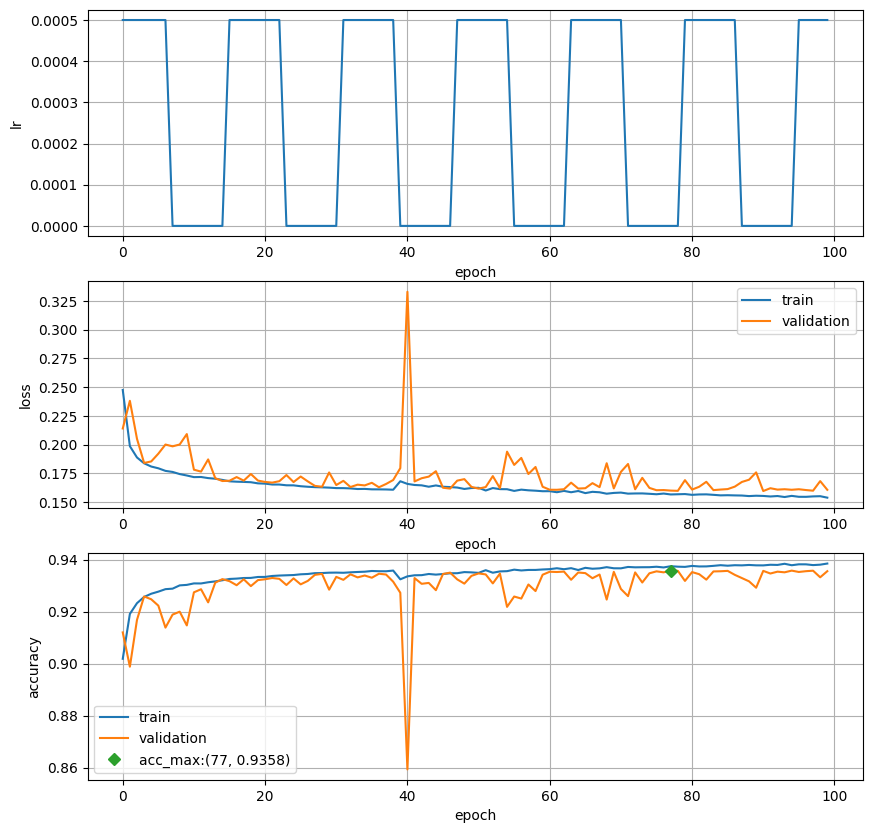

In [113]:
history = pd.read_csv("./models/history.csv")

idx_loss_min = history["val_loss"] == history["val_loss"].min()
idx_acc_max = history["val_acc"] == history["val_acc"].max()

# from cycler import cycler
# plt.rcParams['axes.prop_cycle']  = cycler(color=['#EF4444', '#0EA5E9', '#10B981', '#F59E0B', '#D946EF', '#64748B', '#84CC16', '#6366F1', '#B91C1C'])
plt.rcParams.update(plt.rcParamsDefault)



fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10, 10))
# learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_init, weight_decay=weight_decay)
scheduler = LinearCyclicalLR(optimizer, lr_T, eta_min=lr_init, last_epoch=-1)
lrs = []
for t in range(epochs):
    optimizer.step()
    scheduler.step()
    lrs.append(scheduler.get_lr()[0])

ax[0].plot(history["epoch"], lrs, label="lr")
ax[0].set(
    # yscale="log",
    xlabel = "epoch",
    ylabel= "lr",
)
# ax[0].legend()
ax[0].grid()

ax[1].plot(history["epoch"], history["train_loss"], label="train")
ax[1].plot(history["epoch"], history["val_loss"], label="validation")
# ax[0].plot(
#     history["epoch"][idx_loss_min], history["val_loss"][idx_loss_min],
#     label=f"min:({history['epoch'][idx_loss_min].values[0]}, {history['val_loss'][idx_loss_min].values[0]:.4f})",
#     marker="o", color="green"
# )
ax[1].set(
    xlabel = "epoch",
    ylabel= "loss",
)
ax[1].legend()
ax[1].grid()

ax[2].plot(history["epoch"], history["train_acc"], label="train")
ax[2].plot(history["epoch"], history["val_acc"], label="validation")
ax[2].plot(
    history["epoch"][idx_acc_max], history["val_acc"][idx_acc_max],
    label=f"acc_max:({history['epoch'][idx_acc_max].values[0]}, {history['val_acc'][idx_acc_max].values[0]:.4f})",
    linestyle="", marker="D"
)
ax[2].set(
    xlabel = "epoch",
    ylabel= "accuracy",
)
ax[2].legend()
ax[2].grid()
plt.show()

In [57]:
# recall best model
model.load_state_dict(torch.load(f"./models/model_{str(history['epoch'][idx_acc_max].values[0]).zfill(3)}.pth"))

<All keys matched successfully>

In [ ]:
# test
test_loss, test_acc, y_pred = test(model, test_loader, loss_fn, device)
y_truth = dict_ttv["test"]["label"]

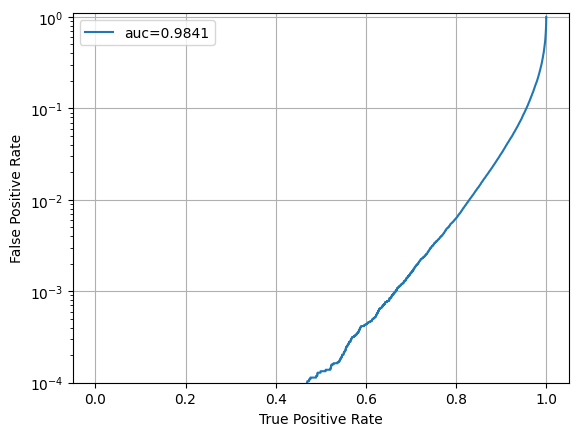

In [114]:
# make ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_truth[:,1], y_pred[:, 1])

fig, ax = plt.subplots()
ax.plot(tpr, fpr, label=f"auc={auc(fpr, tpr):.4f}")
ax.set(
    ylim=(1e-4, 1.1),
    yscale="log",
    xlabel = "True Positive Rate",
    ylabel= "False Positive Rate",
)
ax.legend(loc="upper left")
ax.grid()
plt.show()

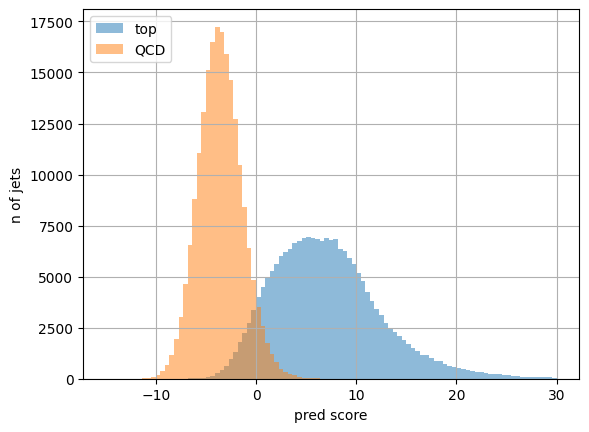

In [115]:
# make pred score distribution
fig, ax = plt.subplots()
bins = np.linspace(-15, 30, 100)
ax.hist(y_pred[:, 1][y_truth[:,1]==1], bins=bins, label="top", alpha=0.5)
ax.hist(y_pred[:, 1][y_truth[:,1]==0], bins=bins, label="QCD", alpha=0.5)
ax.set(
    xlabel = "pred score",
    ylabel= "n of jets",
)
ax.grid()
ax.legend(loc="upper left")
plt.show()